In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import src.models

def plot_score_variable_y(true_score, learned_score, x_min, x_max, y_min, y_max):
    x = jnp.linspace(x_min, x_max, 100)
    y = jnp.linspace(y_min, y_max, 100)
    t = jnp.asarray([0.25, 0.5, 0.75])
    x, y = jnp.meshgrid(x, y)
    x = x[..., None]
    y = y[..., None]

    fig, axs = plt.subplots(nrows=2, ncols=t.size, sharey=True, sharex=True)
    for col, ts in enumerate(t):
        vectorised_learnt_score = jax.vmap(jax.vmap(learned_score, in_axes=(None, 0, 0)), in_axes=(None, 0, 0))
        score_pred = vectorised_learnt_score(ts, x, y)
        pc = axs[0, col].pcolormesh(x.squeeze(), y.squeeze(), score_pred.squeeze())
        axs[0, col].set_title(f"Time: {ts:.2f}")    

    for col, ts in enumerate(t):
        vectorised_score = jax.vmap(jax.vmap(true_score, in_axes=(None, 0, None, 0)), in_axes=(None, 0, None, 0))
        score_true = vectorised_score(ts, x.squeeze(), 1., y.squeeze())
        pc = axs[1, col].pcolormesh(x.squeeze(), y.squeeze(), score_true.squeeze())
    fig.colorbar(pc, ax=axs.ravel().tolist())
    plt.show()
    
    return fig, axs


def plot_score_error_variable_y(true_score, learned_score, x_min, x_max, y_min, y_max):
    x = jnp.linspace(x_min, x_max, 100)
    y = jnp.linspace(y_min, y_max, 100)
    t = jnp.asarray([0.25, 0.5, 0.75])
    x, y = jnp.meshgrid(x, y)
    x = x[..., None]
    y = y[..., None]
    
    fig, axs = plt.subplots(nrows=1, ncols=t.size, sharey=True, sharex=True)
    for col, ts in enumerate(t):
        vectorised_learnt_score = jax.vmap(jax.vmap(learned_score, in_axes=(None, 0, 0)), in_axes=(None, 0, 0))
        score_pred = vectorised_learnt_score(ts, x, y)
        vectorised_score = jax.vmap(jax.vmap(true_score, in_axes=(None, 0, None, 0)), in_axes=(None, 0, None, 0))
        score_true = vectorised_score(ts, x.squeeze(), 1., y.squeeze())
        error = abs(score_pred.squeeze() - score_true.squeeze())
        
        pc = axs[col].pcolormesh(x.squeeze(), y.squeeze(),error)
        axs[col].set_title(f"Time: {ts:.2f}")
    fig.colorbar(pc, ax=axs.ravel().tolist())
    plt.show()
    



In [2]:
import orbax.checkpoint
from src.training import utils

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()


In [6]:
import flax.linen as nn
sde = {"x0": (1.,), "N": 100, "dim": 1, "T": 1., "y": (5.,)}
network = {
    "output_dim": sde["dim"],
    "time_embedding_dim": 16,
    "init_embedding_dim": 16,
    "activation": nn.leaky_relu,
    "encoder_layer_dims": [16],
    "decoder_layer_dims": [128, 128],
}

training = {
    "batch_size": 1000,
    "epochs_per_load": 1,
    "lr": 0.01,
    "num_reloads": 1000,
    "load_size": 1000,
}


num_samples = training["batch_size"] * sde["N"]
x_shape = jnp.empty(shape=(num_samples, sde["dim"]))
t_shape = jnp.empty(shape=(num_samples, 1))
model = src.models.ScoreMLPDistributedEndpt(**network)
empty_train_state = utils.create_train_state(model, jax.random.PRNGKey(0), training["lr"], x_shape, x_shape, t_shape)
target = {"state":empty_train_state, "sde":sde, "network":network, "training":training}

restored = orbax_checkpointer.restore('/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou_varied_y_-1.0_to_1.0', item=target)
train_state = restored["state"]
trained_score = utils.trained_score_variable_y(train_state)


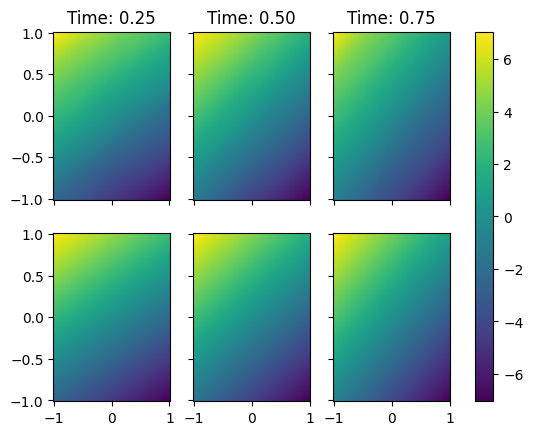

(<Figure size 640x480 with 7 Axes>,
 array([[<Axes: title={'center': 'Time: 0.25'}>,
         <Axes: title={'center': 'Time: 0.50'}>,
         <Axes: title={'center': 'Time: 0.75'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

In [7]:
from src.data_generate_sde import sde_ornstein_uhlenbeck

true_score = sde_ornstein_uhlenbeck.score
plot_score_variable_y(true_score, trained_score, -1, 1, -1, 1)


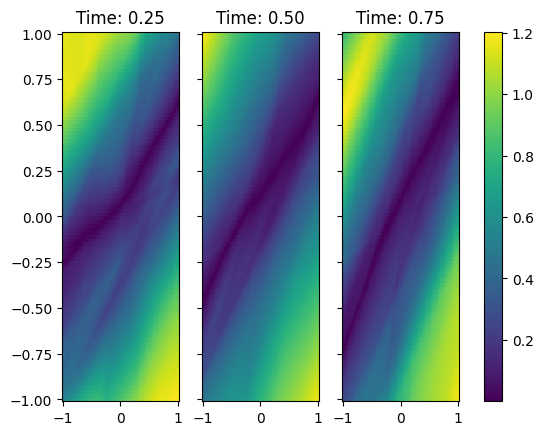

In [8]:
plot_score_error_variable_y(true_score, trained_score, -1, 1, -1, 1)